# Mean reverting startegy based on Bollinger bands Strategy

This notebook answers question 3.5 form the text book Advances in Financial Machine Learning.

3.5 Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [0, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Use as features: volatility, seial correlation, and teh crossinmg moving averages.
* (c) What is teh accuracy of prediction from the primary model? (i.e. if the secondary model does not filter the bets) What are the precision, recall and FI-scores?
* (d) What is teh accuracy of prediction from the primary model? What are the precision, recall and FI-scores?


In [1]:
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score

from mlfinlab.corefns.core_functions import CoreFunctions
from mlfinlab.corefns.financial_functions import FinancialFunctions
from mlfinlab.fracdiff.fracdiff import frac_diff_ffd

import matplotlib.pyplot as plt
%matplotlib inline

### Read in Data
We are using the dollar bars based off of the high quality HFT data we purchased. There is a sample of bars available in this branch as well. 

In [2]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [3]:
data = data['2011-09-01':'2018-01-01']

---
### Define helper functions

In [4]:
def relative_strength_index(df, n):
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)

    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())

    # PosDI = pd.Series(UpI.rolling(window=n).mean())
    # NegDI = pd.Series(DoI.rolling(window=n).mean())

    RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
    # df = df.join(RSI)
    return RSI

    
# Compute RSI
def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = FinancialFunctions.relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [5]:
def compute_side(data):
    # Apply Bolinger band strategy
    """
    The following is a mean reverting strategy using Bollinger Bands:
    * If price above upper band then short.
    * If price below bottom band then long.
    * If price cross mean price then close all positions.
    """
    current_side = 0

    store = []
    for row in data.itertuples():
            # Buy signal
            if row.close > row.upper and current_side != -1:
                current_side = -1
                store.append(current_side)

            # Short signal
            elif row.close < row.lower and current_side != 1:
                current_side = 1
                store.append(current_side)

            # Close signal long
            elif current_side == 1 and row.close > row.avg:
                current_side = 0
                store.append(current_side)

            # Close signal short
            elif current_side == -1 and row.close < row.avg:
                current_side = 0
                store.append(current_side)

            # No action
            else:
                store.append(current_side)
    return store

---
### Fit a Primary Model: Mean-reverting based on Bollinger bands
Based on the mean-reverting Bollinger band strategy.


In [6]:
# compute bands
window = 50
data['avg'], data['upper'], data['lower'] = FinancialFunctions.bbands(data['close'], window, no_of_stdev=2)
data.sample(10)

open     high      low    close  cum_vol  \
date_time                                                              
2016-04-27 17:22:18.268  2084.25  2084.25  2081.50  2081.75    33609   
2012-05-17 19:48:23.568  1304.75  1305.25  1304.25  1305.25    53956   
2013-06-14 16:44:29.482  1625.00  1626.75  1623.50  1626.00    43075   
2015-03-04 16:03:35.378  2089.25  2091.50  2088.25  2091.25    33496   
2014-11-12 19:32:56.003  2035.00  2036.50  2034.00  2035.50    34405   
2011-11-10 16:05:42.532  1229.00  1232.75  1227.75  1232.00    56878   
2014-09-03 19:59:59.078  1999.00  1999.75  1998.75  1999.00    35035   
2017-11-22 18:07:26.363  2595.00  2596.00  2594.25  2595.50    27036   
2016-11-14 14:59:27.617  2164.00  2165.00  2160.50  2160.75    32437   
2016-09-08 15:10:20.634  2180.75  2183.00  2180.75  2182.75    32142   

                          cum_dollar  cum_ticks       avg        upper  \
date_time                                                                
2016-04-27 17:22:18.268  70008308.25       4211  2083.155  2088.510609   
2012-05-17 19:48:23.568  70395303.75       4878  1316.565  1327.356536   
2013-06-14 16:44:29.482  70003168.50      11951  1626.035  1639.950932   
2015-03-04 16:03:35.378  70008558.00      11407  2097.820  2110.635822   
2014-11-12 19:32:56.003  70019528.75      11195  2033.575  2038.396561   
2011-11-10 16:05:42.532  70008400.50      13438  1232.475  1244.994067   
2014-09-03 19:59:59.078  70043489.00       4835  2001.365  2009.747568   
2017-11-22 18:07:26.363  70160254.75       2165  2597.315  2600.071828   
2016-11-14 14:59:27.617  70159584.75       4132  2159.110  2170.608962   
2016-09-08 15:10:20.634  70137418.25       2277  2181.410  2186.609843   

                               lower  
date_time                             
2016-04-27 17:22:18.268  2077.799391  
2012-05-17 19:48:23.568  1305.773464  
2013-06-14 16:44:29.482  1612.119068  
2015-03-04 16:03:35.378  2085.004178  
2014-11-12 19:32:56.003  2028.753439  
2011-11-10 16:05:42.532  1219.955933  
2014-09-03 19:59:59.078  1992.982432  
2017-11-22 18:07:26.363  2594.558172  
2016-11-14 14:59:27.617  2147.611038  
2016-09-08 15:10:20.634  2176.210157

In [15]:
# Compute 
rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

9054
9041


In [27]:
# data['side'] = compute_side(data)
long_signals = (data['close'] <= data['lower']) & (data['rsi'] <= 25)
short_signals = (data['close'] >= data['upper']) & (data['rsi'] >= 75) 
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)


In [28]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [29]:
# print(data.sample(5))
print(data.side.value_counts())

-1.0    4952
 1.0    4087
Name: side, dtype: int64


### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [30]:
# Compute daily volatility
daily_vol = CoreFunctions.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = CoreFunctions.get_t_events(data['close'], threshold=daily_vol.mean() * 0.1)

# Compute vertical barrier
vertical_barriers = CoreFunctions.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

Calculating daily volatility for dynamic thresholds
Applying Symmetric CUSUM filter.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9037/9037 [00:01<00:00, 6743.94it/s]


In [41]:
pt_sl = [1, 2]
triple_barrier_events = CoreFunctions.get_events(close=data['close'],
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=0.01,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=data['side'])

2019-03-06 22:24:48.633141 100.0% apply_pt_sl_on_t1 done after 0.05 minutes. Remaining 0.0 minutes.


In [42]:
labels = CoreFunctions.get_bins(triple_barrier_events, data['close'])

---
### Results of Primary Model:
What is the accuracy of predictions from the primary model (i.e., if the sec- ondary model does not filter the bets)? What are the precision, recall, and F1-scores?

In [43]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1575
           1       0.20      1.00      0.34       400

   micro avg       0.20      0.20      0.20      1975
   macro avg       0.10      0.50      0.17      1975
weighted avg       0.04      0.20      0.07      1975

Confusion Matrix
[[   0 1575]
 [   0  400]]

Accuracy
0.20253164556962025


---
## Fit a Meta Model
Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

Create the following features: 
* Volatility
* Serial Correlation
* The returns at the different lags from the serial correlation
* The sides from the SMavg Strategy

In [40]:
raw_data.head()

open     high      low    close  cum_vol  \
date_time                                                              
2011-09-02 15:27:35.512  1183.00  1184.50  1181.25  1182.75    59181   
2011-09-02 15:42:44.229  1183.00  1185.00  1181.75  1183.75    59163   
2011-09-02 16:02:52.327  1183.75  1184.50  1180.50  1182.00    59217   
2011-09-02 16:33:54.667  1182.00  1184.75  1180.75  1181.50    59185   
2011-09-02 17:00:38.204  1181.50  1182.75  1180.75  1181.75    59246   

                          cum_dollar  cum_ticks  avg  upper  lower  rsi  side  
date_time                                                                      
2011-09-02 15:27:35.512  70001932.50      15133  NaN    NaN    NaN  NaN   NaN  
2011-09-02 15:42:44.229  70003656.75      16227  NaN    NaN    NaN  NaN   0.0  
2011-09-02 16:02:52.327  70007894.75      15588  NaN    NaN    NaN  NaN   0.0  
2011-09-02 16:33:54.667  70000538.75      17609  NaN    NaN    NaN  NaN   0.0  
2011-09-02 17:00:38.204  70009944.50      13769  NaN    NaN    NaN  NaN   0.0

### Features

In [41]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

In [20]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [21]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Now get the data at the specified events

In [23]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']

### Fit a model

In [24]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, shuffle=False)

In [25]:
# Random Forest Model
n_estimator = 50
c_random_state = 42
depth = 9

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Training Metrics

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       125
           1       1.00      0.99      1.00       107

   micro avg       1.00      1.00      1.00       232
   macro avg       1.00      1.00      1.00       232
weighted avg       1.00      1.00      1.00       232

Confusion Matrix
[[125   0]
 [  1 106]]

Accuracy
0.36774193548387096


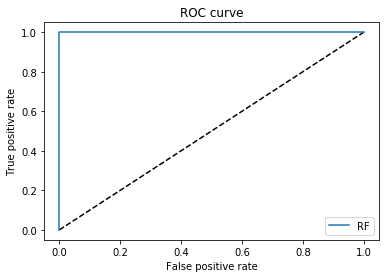

In [26]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

This is overfitting big time but I'll leave the hyper param tuning to other enthusiast. 

#### Test Metrics

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       365
           1       0.40      0.44      0.42       178

   micro avg       0.60      0.60      0.60       543
   macro avg       0.55      0.56      0.56       543
weighted avg       0.61      0.60      0.60       543

Confusion Matrix
[[245 120]
 [ 99  79]]

Accuracy
0.36774193548387096


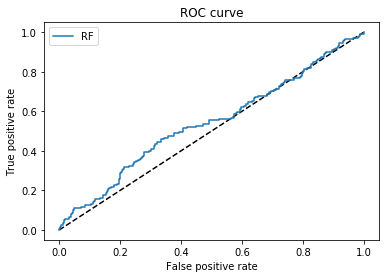

In [27]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

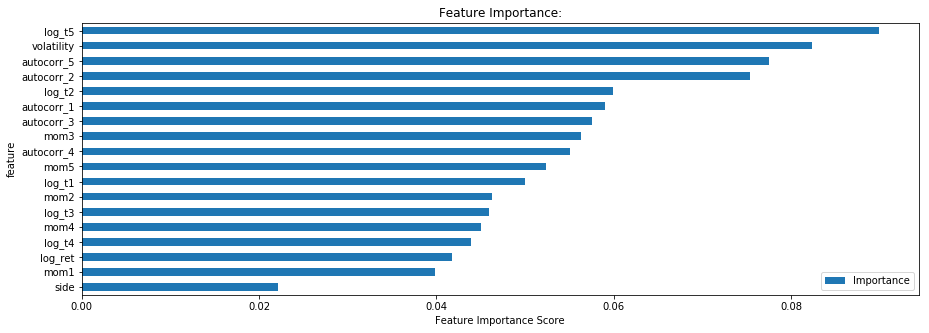

In [37]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

Note how low the side is ranked. If we look at the performance of the primary model we will see that the SMA strategy gets only 36% of the trades correct.

---
## Performance Tear Sheets

In [29]:
test_dates = X_test.index

print(pf.show_perf_stats(labels.loc[test_dates, 'ret']))
print(pf.show_worst_drawdown_periods(labels.loc[test_dates, 'ret']))

None


/home/ariadne/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


None


In [30]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred

print(pf.show_perf_stats(meta_returns))
print(pf.show_worst_drawdown_periods(meta_returns))

None


None


---
## Conclusion
It would seem that the biggest problem here is the moving average strategy. It is not a good signal!

You can play around with the model and the metrics. Interesting to see the difference if you shuffel the data vs not. 

Its great to see in this notebook that meta labeling helped to improve the portfolio's performance metrics by reducing the drawdown and increaseing the returns from -17% to a 2.6%